In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Step 2: Load the dataset
file_path = "Customer_Data.csv"  # Change this to your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)



In [ ]:
# Step 3: Data Preprocessing (Selecting numerical features)
df.printSchema()  # Check schema to identify numeric columns
features = ["purchases_frequency", "balance_frequency"]  # Replace with actual numeric column names




root
 |-- cust_id: string (nullable = true)
 |-- balance: double (nullable = true)
 |-- balance_frequency: double (nullable = true)
 |-- purchases: double (nullable = true)
 |-- oneoff_purchases: double (nullable = true)
 |-- installments_purchases: double (nullable = true)
 |-- cash_advance: double (nullable = true)
 |-- purchases_frequency: double (nullable = true)
 |-- oneoff_purchases_frequency: double (nullable = true)
 |-- purchases_installments_frequency: double (nullable = true)
 |-- cash_advance_frequency: double (nullable = true)
 |-- cash_advance_trx: integer (nullable = true)
 |-- purchases_trx: integer (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- payments: double (nullable = true)
 |-- minimum_payments: double (nullable = true)
 |-- prc_full_payment: double (nullable = true)
 |-- tenure: integer (nullable = true)



In [ ]:
# Step 4: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(df)

# Step 5: Standardize the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)



In [ ]:
# Step 6: Apply K-Means Clustering
kmeans = KMeans(featuresCol="scaledFeatures", k=3)  # Choose k=3, adjust as needed
model = kmeans.fit(scaled_data)
clusters = model.transform(scaled_data)

# Step 7: Show results
clusters.select("purchases_frequency", "balance_frequency", "prediction").show(10)  # Replace with actual feature names



+-------------------+-----------------+----------+
|purchases_frequency|balance_frequency|prediction|
+-------------------+-----------------+----------+
|           0.166667|         0.818182|         1|
|                0.0|         0.909091|         1|
|                1.0|              1.0|         0|
|           0.083333|         0.636364|         2|
|           0.083333|              1.0|         1|
|           0.666667|              1.0|         0|
|                1.0|              1.0|         0|
|                1.0|              1.0|         0|
|           0.333333|              1.0|         1|
|           0.166667|         0.545455|         2|
+-------------------+-----------------+----------+
only showing top 10 rows



In [ ]:
# Step 8: Evaluate clustering performance (Inertia / Within Set Sum of Squared Errors - WSSSE)
wssse = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors (WSSSE): {wssse}")



Within Set Sum of Squared Errors (WSSSE): 3421.775243894265


In [ ]:
# Convert PySpark DataFrame to Pandas
clusters_pd = clusters.select("purchases_frequency", "balance_frequency", "prediction").toPandas()

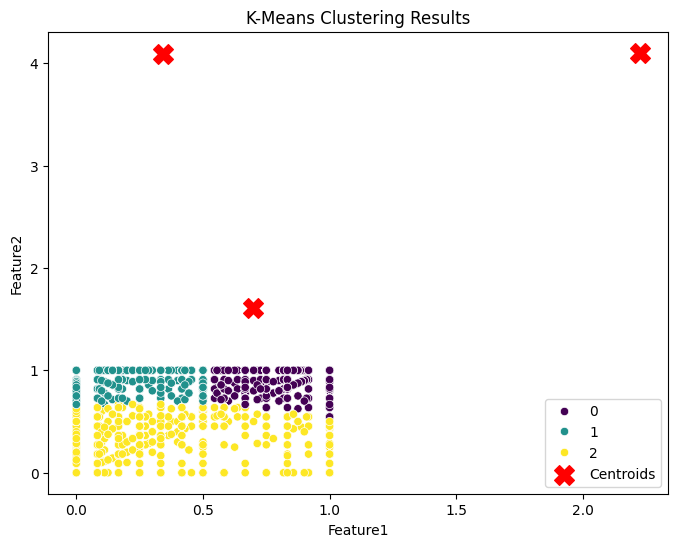

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="purchases_frequency", y="balance_frequency", hue="prediction", palette="viridis", data=clusters_pd
)
centers = np.array(model.clusterCenters())

# Scatter plot with corrected indexing
plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='X', s=200, label="Centroids")

plt.title("K-Means Clustering Results")
plt.xlabel("Feature1")  # Change to actual feature name
plt.ylabel("Feature2")  # Change to actual feature name
plt.legend()
plt.show()

In [ ]:
# Stop Spark session
spark.stop()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("PimaRandomForestDecisionTree").getOrCreate()

# Read CSV file (assuming the first row is header and types are inferred)
df = spark.read.csv("/content/pima.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+----+----+----+----+----+----+-----+---+---------------+
|Preg|Plas|Pres|Skin|Insu|Mass| Pedi|Age|          Class|
+----+----+----+----+----+----+-----+---+---------------+
|  14| 175|  62|  30|   0|33.6|0.212| 38|tested_positive|
|   4| 146|  78|   0|   0|38.5| 0.52| 67|tested_positive|
|  15| 136|  70|  32| 110|37.1|0.153| 43|tested_positive|
|   3| 107|  62|  13|  48|22.9|0.678| 23|tested_positive|
|   3| 169|  74|  19| 125|29.9|0.268| 31|tested_positive|
+----+----+----+----+----+----+-----+---+---------------+
only showing top 5 rows

root
 |-- Preg: integer (nullable = true)
 |-- Plas: integer (nullable = true)
 |-- Pres: integer (nullable = true)
 |-- Skin: integer (nullable = true)
 |-- Insu: integer (nullable = true)
 |-- Mass: double (nullable = true)
 |-- Pedi: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Class: string (nullable = true)



In [ ]:
# Assume the last column is the target
columns = df.columns
feature_columns = columns[:-1]  # All columns except the target
target_column = columns[-1]
print("Target column:", target_column)

# Rename the target column to 'label' for ML
df = df.withColumnRenamed(target_column, "label")

# Assemble features into a single vector column 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df).select("features", "label")

# Split the dataset into training and testing sets (70/30 split)
train, test = data.randomSplit([0.7, 0.3], seed=42)

Target column: class


In [ ]:
##############################
# Random Forest Classifier
##############################

# Initialize and train the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, seed=42)
rf_model = rf.fit(train)

# Generate predictions on the test set
rf_predictions = rf_model.transform(test)

# Evaluate the model using AUC (Area Under ROC)
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
rf_auc = evaluator_auc.evaluate(rf_predictions)
print("Random Forest AUC:", rf_auc)

# Compute precision, recall, and accuracy using MulticlassMetrics
# MulticlassMetrics expects an RDD of (prediction, label) pairs
rf_pred_rdd = rf_predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
metrics_rf = MulticlassMetrics(rf_pred_rdd)
rf_precision = metrics_rf.precision(1.0)  # Assuming the positive class is labeled 1.0
rf_recall = metrics_rf.recall(1.0)
rf_accuracy = metrics_rf.accuracy
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest Accuracy:", rf_accuracy)

# Print feature importances from the Random Forest model
print("Random Forest Feature Importances:")
for col, imp in zip(feature_columns, rf_model.featureImportances):
    print(f"{col}: {imp}")


Random Forest AUC: 0.8238573021181713
Random Forest Precision: 0.6666666666666666
Random Forest Recall: 0.5797101449275363
Random Forest Accuracy: 0.7537688442211056
Random Forest Feature Importances:
preg: 0.07423774049802578
plas: 0.33818285120085156
pres: 0.048528078434346214
skin: 0.03609356770004231
test: 0.051652411396612724
mass: 0.16982738365242017
pedi: 0.0810134543900141
age: 0.2004645127276872


In [ ]:
##############################
# Decision Tree Classifier
##############################

# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=42)
dt_model = dt.fit(train)

# Generate predictions on the test set
dt_predictions = dt_model.transform(test)

# Evaluate the Decision Tree model using AUC
dt_auc = evaluator_auc.evaluate(dt_predictions)
print("Decision Tree AUC:", dt_auc)

# Compute precision, recall, and accuracy for Decision Tree
dt_pred_rdd = dt_predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
metrics_dt = MulticlassMetrics(dt_pred_rdd)
dt_precision = metrics_dt.precision(1.0)
dt_recall = metrics_dt.recall(1.0)
dt_accuracy = metrics_dt.accuracy
print("Decision Tree Precision:", dt_precision)
print("Decision Tree Recall:", dt_recall)
print("Decision Tree Accuracy:", dt_accuracy)

Decision Tree AUC: 0.6408026755852843
Decision Tree Precision: 0.6724137931034483
Decision Tree Recall: 0.5652173913043478
Decision Tree Accuracy: 0.7537688442211056


In [ ]:
# Optionally, print the Decision Tree structure for debugging/interpretability
print("Decision Tree Model Structure:")
print(dt_model.toDebugString)

# Stop the Spark session when finished
spark.stop()

Decision Tree Model Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9d1a8900dc3a, depth=5, numNodes=37, numClasses=2, numFeatures=8
  If (feature 1 <= 137.5)
   If (feature 7 <= 30.5)
    If (feature 0 <= 6.5)
     Predict: 0.0
    Else (feature 0 > 6.5)
     If (feature 2 <= 15.0)
      If (feature 7 <= 29.5)
       Predict: 0.0
      Else (feature 7 > 29.5)
       Predict: 1.0
     Else (feature 2 > 15.0)
      Predict: 1.0
   Else (feature 7 > 30.5)
    If (feature 5 <= 27.35)
     If (feature 2 <= 93.0)
      Predict: 0.0
     Else (feature 2 > 93.0)
      Predict: 1.0
    Else (feature 5 > 27.35)
     If (feature 1 <= 94.5)
      If (feature 6 <= 0.764)
       Predict: 0.0
      Else (feature 6 > 0.764)
       Predict: 1.0
     Else (feature 1 > 94.5)
      If (feature 6 <= 0.558)
       Predict: 0.0
      Else (feature 6 > 0.558)
       Predict: 1.0
  Else (feature 1 > 137.5)
   If (feature 1 <= 155.5)
    If (feature 2 <= 89.0)
     If (feature 2 <= 57.0)
